In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
import sys; sys.path.append('..')

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import torch
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from lib.minimizer_callback import MinimizerCallback
from lib.widgets.mlp_response_view import show_mlp_response_3d

# 2. Multi-layer perceptron and backpropagation

A general feedforward network consists of at least one layer, and it can also contain an arbitrary number of hidden layers. Neurons
in a given layer can be defined by any activation function. In the hidden layers usually nonlinear activation functions are used, e.g. the [hyperbolic tangent function](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh), the [logistic function](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid) or the [ReLU function](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU). Depending on the application, a nonlinear activation function can also be used in the output layer, or the [identity function](https://pytorch.org/docs/stable/generated/torch.nn.Identity.html#torch.nn.Identity) can be used (leaving the output unchanged). The only important condition is that there is no feedback in the network, neither delay.

Below, we create a synthetic dataset containing samples from the function $y(x_1, x_2) = \frac{\sin(x_1) + \cos(x_2)}{2}$.

In [2]:
# A batch of (x0, x1) inputs
x1s = torch.linspace(-torch.pi, torch.pi, 10)
x2s = torch.linspace(-torch.pi, torch.pi, 10)
x = torch.cartesian_prod(x1s, x2s)

# A batch of desired outputs y
y = (torch.sin(x[:, 0]) + torch.cos(x[:, 1]))[:, None]/2

When visualizing these samples, it is clear that a simple perceptron would never be able to model this. Instead, we will create an MLP to fit the data. By adding a hidden layer with a non-linear activation, you will see that the response of the MLP is much more flexible than the perceptron.

In [3]:
fig = go.Figure(data=[
    go.Scatter3d(x=x[:, 0], y=x[:, 1], z=y[:, 0],
                 mode='markers', marker=dict(
                     color=y[:, 0],
                     colorscale='Viridis',
                 ))
])
fig.show()

## 2.1 Implement your own MLP

To implement an MLP in PyTorch, we will again create a class that inherits from `torch.nn.Module`. We will first implement an MLP with **a single hidden layer**. This is very similar to our Perceptron, we only need to add an extra layer and activation.

**Copy the code below and paste it into a code cell and complete it to create your first MLP!** You can choose the activations yourself. See [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for some available options. Typical choices are [nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh), [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid) or [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU). Make sure to understand the properties of the activation function you are using.


```python
class MLP_1HL(nn.Module):
    """
    A multilayer perceptron with one hidden layer.
    """
    def __init__(
        self,
        num_input_neurons,
        num_hidden_neurons,
        num_output_neurons
    ):
        super().__init__()

        # Define first layer
        self.layer0 = # An nn.Linear layer that transforms num_input_neurons to num_hidden_neurons and adds a bias
        self.activ0 = # A non-linear activation function

        # Define second layer
        self.layer1 = # An nn.Linear layer that transforms num_hidden_neurons to num_output_neurons and adds a bias
        self.activ1 = # The output activation function

        # Store these for easy access
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons

    def forward(self, x):
        # Pass through first layer
        x = self.layer0(x)
        x = self.activ0(x)

        # Pass through second layer
        x = self.layer1(x)
        y = self.activ1(x)

        return y
```

In [4]:
class MLP_1HL(nn.Module):
    """
    A multilayer perceptron with one hidden layer.
    """
    def __init__(
        self,
        num_input_neurons,
        num_hidden_neurons,
        num_output_neurons
    ):
        super().__init__()

        # Define first layer
        self.layer0 = nn.Linear(num_input_neurons, num_hidden_neurons, bias=True) # An nn.Linear layer that transforms num_input_neurons to num_hidden_neurons and adds a bias
        self.activ0 = nn.ReLU() # A non-linear activation function

        # Define second layer
        self.layer1 = nn.Linear(num_hidden_neurons, num_output_neurons, bias=True) # An nn.Linear layer that transforms num_hidden_neurons to num_output_neurons and adds a bias
        self.activ1 = nn.Tanh() # The output activation function, we have to use tanh since the output prediction is between -1 and 1

        # Store these for easy access
        self.num_input_neurons = num_input_neurons
        self.num_hidden_neurons = num_hidden_neurons
        self.num_output_neurons = num_output_neurons

    def forward(self, x):
        # Pass through first layer
        x = self.layer0(x)
        x = self.activ0(x)

        # Pass through second layer
        x = self.layer1(x)
        y = self.activ1(x)

        return y

Now, you can create an MLP with 2 input neurons, a hidden layer with 10 neurons and 1 output neuron by executing the following cell.

In [5]:
mlp_1hl = MLP_1HL(
    num_input_neurons=2,
    num_hidden_neurons=10,
    num_output_neurons=1
)

## 2.2 Training an MLP with gradient descent-based optimizers

### 2.2.1 Creating an optimizer

An MLP is often trained with a gradient descent-based optimization algorithm, like [stochastic gradient descent (SGD)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html). PyTorch contains many such optimizers. Some frequently-used optimizers are:

- [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
- [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)
- [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)

A full list can be found [here](https://pytorch.org/docs/stable/optim.html#algorithms). For example, to create an SGD optimizer object in PyTorch, you do:

In [6]:
optimizer = optim.SGD(
    params=mlp_1hl.parameters(),  # The model parameters (weights and biases)
    lr=0.1  # The learning rate
)

As you can see, you must pass the model parameters to the optimizer's constructor, along with the optimizer-specific settings (like learning rate for SGD). We chose an arbitrary value of `0.1` for the learning rate, which might be suboptimal. Once you start experimenting, it is very important to try **different values for the learning rate**, as this might greatly influence how well your model converges.

Gradient descent-based optimization algorithms use the **gradient of the loss value with respect to the model's parameters**. By updating the model parameters in the opposite direction of the loss gradient, the loss value should decrease. In other words, our model should become better.

### 2.2.2 Creating a loss function

To compute the *gradient* of the loss value, we first need the loss value itself. This value is produced by a **loss function**: a differentiable function that indicates *how bad* the outputs of a model are with respect to the desired outputs. Which loss function to use heavily depends on the application and can greatly influence the final performance of your model. For now, we will use the [mean-squared error loss function](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss).

We can create an MSE loss function object like so:

In [7]:
loss_fn = nn.MSELoss()

To use this loss function, we first let our model predict the outputs of some training data.

In [8]:
y_pred = mlp_1hl(x)

Now, we pass the *predicted* output values `y_pred` and the *desired* output values `y` to the loss function to obtain the **loss value**:

In [9]:
loss = loss_fn(y_pred, y)

print(loss)

tensor(0.3876, grad_fn=<MseLossBackward0>)


### 2.2.3 Computing the gradient of the loss

But how can we compute the *gradient* of this loss value with respect to the model parameters?

Well, that's where ✨ **the PyTorch magic** ✨ comes in! PyTorch contains an *automatic differentiation engine* called `torch.autograd` (more info [here](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)). Thanks to `torch.autograd`, computing the gradient of the loss w.r.t. the model parameters is as easy as calling `loss.backward()`:

In [10]:
loss.backward()

Now, you can check the gradient of the loss w.r.t. each parameter in the multi-layer perceptron:

In [11]:
print(mlp_1hl.layer0.weight.grad)
print(mlp_1hl.layer0.bias.grad)

print(mlp_1hl.layer1.weight.grad)
print(mlp_1hl.layer1.bias.grad)

tensor([[-0.0178,  0.0207],
        [ 0.0028, -0.0003],
        [ 0.1898, -0.0099],
        [ 0.0162, -0.0210],
        [ 0.0170, -0.0016],
        [-0.1079, -0.0041],
        [ 0.2292,  0.0100],
        [ 0.0000,  0.0000],
        [-0.1639,  0.1154],
        [ 0.0124,  0.0004]])
tensor([-1.1100e-06, -1.2578e-03,  5.7096e-02,  3.1626e-03, -6.1906e-03,
        -2.0280e-02,  4.0277e-02,  0.0000e+00,  1.7622e-02,  2.5446e-03])
tensor([[ 0.0676,  0.4151, -0.2610, -0.2253,  0.1660, -0.1698, -0.4377,  0.0000,
          0.0376, -0.3912]])
tensor([0.1640])


### 2.2.4 Performing an optimization step

Our optimizer has a reference to our model parameters (since we have passed them into the constructor), so the optimizer can also see these gradients! Even more, the optimizer can try to *improve* the model parameters by changing them in the direction opposite to the gradient. To perform this optimization step, we simply call `optimizer.step()`.

In [12]:
optimizer.step()

### 2.2.5 Putting it all inside a training loop

We have encapsulated our training logic into a reusable function below. As you might have noticed, we have added one extra function call: `optimizer.zero_grad()`. This is to avoid that the gradients will accumulate with the gradients of the previous iteration.

In [13]:
def training_step(model, x_train, y_train, loss_fn, optimizer, writer, epoch):
    """
    Perform a single training step

    Args:
        model: The neural network.
        x_train: The input training data.
        y_train: The desired output training data.
        loss_fn: The loss function.
        optimizer: The optimizer.
        writer: `SummaryWriter` object used to log the training loss
            to TensorBoard.
        epoch: The current epoch number.
    """
    # Pass the training data through the model
    y_pred = model(x_train)

    # Compute the loss value
    loss = loss_fn(y_pred, y_train)

    # Clean up gradients from previous iteration
    optimizer.zero_grad()

    # Compute grad of loss wrt model params
    loss.backward()

    # Take optimization step
    optimizer.step()

    # Log the training loss
    writer.add_scalar(f"{loss_fn.__class__.__name__}/Train", loss, epoch)

With this function, we can easily create a training loop. First, we define our model, optimizer and loss function.

In [14]:
# 1. Define your model
mlp_1hl = MLP_1HL(
    num_input_neurons=2,
    num_hidden_neurons=10,
    num_output_neurons=1
)

# 2. Create an optimizer
optimizer = optim.SGD(
    params=mlp_1hl.parameters(),  # The model parameters (weights and biases)
    lr=1.0  # The learning rate. Also try other values!!
)

# 3. Create a loss function
loss_fn = nn.MSELoss()

Now, we can easily create a loop that executes this training step for a given number of epochs. Note that we put the number of hidden neurons in our run name.

In [15]:
LOG_DIR = 'runs_mlp'  # This is the name of the directory in which we will put the TensorBoard logs

# Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'[{mlp_1hl.num_hidden_neurons}]_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')


NUM_EPOCHS = 2000

for epoch in tqdm(range(NUM_EPOCHS)):
    training_step(mlp_1hl, x, y, loss_fn, optimizer, writer, epoch)

100%|██████████| 2000/2000 [00:00<00:00, 2268.97it/s]


Start a new TensorBoard from the OnDemand dashboard with `anndl_es1_files/es1/runs_mlp` as value for the "Project/Log folder". You can kill the TensorBoard of the previous notebook.

Finally, let's take a look at the response of our MLP.

In [16]:
show_mlp_response_3d(mlp_1hl, x, y)

### 2.2.6 Adding momentum, weight decay etc. to an optimizer

Optimizers typically contain one or more **hyperparameters** that you can configure. Learning rate is the most common one, but there are many more to explore, such as `weight_decay` (for regularization). Some notable ones:

- For [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD): `momentum`, `weight_decay`
- For [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad):  `lr_decay`, `weight_decay`
- For [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam): `betas`, `weight_decay`
- For [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop): `alpha`, `momentum`, `weight_decay`

## 2.3 Keeping an eye on generalization

Achieving a low training loss is no guarantee that our model will work in practice. It could very well be that the model has *overfit* the training data. To keep an eye on the generalization capabilities of our model, we can **regularly log the loss on an unseen validation dataset**. Once the validation loss starts to increase, this indicates that the model is overfitting the training data.

Of course, we must not train on the validation data, so we don't need to compute any gradients. This can be done with the `torch.no_grad()` decorator.

We have implemented a single validation step below.

In [17]:
@torch.no_grad()
def validation_step(model, x_val, y_val, loss_fn, writer, epoch):
    """
    Compute an log the validation loss.
    
    Args:
        model: The neural network.
        x_val: The input validation data.
        y_val: The desired output validation data.
        loss_fn: The loss function.
        writer: `SummaryWriter` object used to log the validation loss
            to TensorBoard.
        epoch: The current epoch number.
    """
    # Pass the validation data through the model
    y_pred = model(x_val)

    # Compute the loss value
    val_loss = loss_fn(y_pred, y_val)

    # Log the training loss
    writer.add_scalar(f"{loss_fn.__class__.__name__}/Val", val_loss, epoch)

We can now create a new loop that combines a training and validation step. First, we create a new model, optimizer and loss function.

In [18]:
# 1. Define your model
mlp_1hl = MLP_1HL(
    num_input_neurons=2,
    num_hidden_neurons=10,
    num_output_neurons=1
)

# 2. Create an optimizer
optimizer = optim.SGD(
    params=mlp_1hl.parameters(),  # The model parameters (weights and biases)
    lr=1.0  # The learning rate
)

# 3. Create a loss function
loss_fn = nn.MSELoss()

We split our dataset into a training set and a validation set.

In [19]:
num_train = int(len(x)*0.75)  # Use 75% of data for training

# Get the indices of the samples to use for training and validation
train_idxs, val_idxs = torch.randperm(len(x)).split(num_train)

In [20]:
x_train = x[train_idxs]
x_val = x[val_idxs]

y_train = y[train_idxs]
y_val = y[val_idxs]

Finally, we create a loop and call `training_step()` and `validation_step()` sequentially.

In [21]:
# Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'[{mlp_1hl.num_hidden_neurons}]_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')


NUM_EPOCHS = 10000

for epoch in tqdm(range(NUM_EPOCHS)):
    training_step(mlp_1hl, x_train, y_train, loss_fn, optimizer, writer, epoch)
    validation_step(mlp_1hl, x_val, y_val, loss_fn, writer, epoch)

100%|██████████| 10000/10000 [00:06<00:00, 1461.81it/s]


Open your TensorBoard window and click the refresh button. You should see a graph for both the training and the validation loss.

We can also check the response of our MLP.

In [22]:
show_mlp_response_3d(mlp_1hl, x_val, y_val)

## 2.4 Second-order optimizers

A gradient descent-based optimizer only uses the first-order gradient of the loss value w.r.t. the model paramters. If we would also know the *second-order gradient* (i.e., the *gradient of the gradient*), we know how the first-order gradient will change when changing the model parameters. This information could improve the optimization.

The library [`torchmin`](https://github.com/rfeinman/pytorch-minimize) contains implementations of some second-order optimizers.

Below, you can find a code example of how to use this library to train an MLP. As you can see there are multiple second-order optimizers available:

- **BFGS**/**L-BFGS**. BFGS is a cannonical quasi-Newton method for unconstrained optimization.
- **Conjugate Gradient** (CG). The conjugate gradient algorithm is a generalization of linear conjugate gradient to nonlinear optimization problems. Pytorch-minimize includes an implementation of the **Polak-Ribiére** CG algorithm described in Nocedal & Wright (2006) chapter 5.2.
- **Newton Conjugate Gradient** (NCG). The Conjugate Gradient (CG) variant of Newton's method is an effective solution for unconstrained minimization with Hessian-vector products.
- **Newton Exact**. An "exact" variant of Newton's method that computes the full Hessian matrix.

In [23]:
from torchmin import Minimizer


# 1. Define your model
mlp = MLP_1HL(
    num_input_neurons=2,
    num_hidden_neurons=10,
    num_output_neurons=1
)


# 2. Create a loss function
loss_fn = nn.MSELoss()


# 3. Choose an optimization method. Available methods are:
#    - 'bfgs'
#    - 'l-bfgs'
#    - 'cg'
#    - 'newton-cg'
#    - 'newton-exact'
METHOD = 'bfgs'


# 4. Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')
run_name = f'[{mlp.num_hidden_neurons}]_{METHOD}_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')


# This callback is necessary for logging the results to TensorBoard
callback = MinimizerCallback(
    mlp, loss_fn, writer,
    x_train, y_train,
    x_val, y_val
)


# 5. Create the 2nd order optimizer
optimizer = Minimizer(
    mlp.parameters(),
    method=METHOD,
    max_iter=10000,  # The maximum number of iterations
    callback=callback
)

The training itself is done in a slightly different way than with first-order optimizers. We call `optimizer.step()` only once now. This kicks off the optimization and it will finish once the entire optimization procedure has finished, or when the maximum number of iterations is reached (which we set with the `max_iter` argument of the `Minimizer`).

Additionaly, `optimizer.step()` requires a *closure* function which should re-evaluate the loss, as shown below.

In [24]:
def closure():
    optimizer.zero_grad()
    output = mlp(x_train)
    loss = loss_fn(output, y_train)
    return loss


loss = optimizer.step(closure)

Check TensorBoard to see the logged loss values.

We can also visually verify the result.

In [25]:
show_mlp_response_3d(mlp, x_val, y_val)

## 2.5 Exercises

For the exercises, you can use a slightly more advanced MLP implementation. You import it as follows:

```python
from lib.models.mlp import MLP
```

And it can be instanstiated, for example, like so:

```python
mlp = MLP(
    num_input_neurons=1,  # A single input neuron
    num_hidden_neurons=[10, 5],  # Two hidden layers, first one has 10 neurons, second one 5
    num_output_neurons=1,  # A single output neuron
    activation='ReLU',  # Activation in hidden layers. 'Tanh', 'ReLU', 'Sigmoid' or None (= Identity)
    output_activation=None,  # Activation in output layer. 'Tanh', 'ReLU', 'Sigmoid' or None (= Identity)
)
```

As you can see, this MLP implementation allows you to create an MLP with more than one hidden layer and allows you to specify the activation function to use in the hidden layers and in the output layer.

> **NOTE**: `NameError` after restarting the notebook kernel
>
> After restarting the notebook kernel, you might get a `NameError` error (e.g, `NameError: name 'torch' is not defined`)  when you try to execute a cell. This is because you either didn't import a library or you didn't define a function or variable yet. The **first cell of this notebook** contains all imports you'll need, so, to avoid `NameError`s, always execute this cell first. Additionally, execute **any cell that contains a function definition you need** (e.g., the cells defining `training_step()` and `validation_step()`).

### 2.5.1 Function approximation: comparison of various algorithms

Take the function $y = \sin(x^2)$ for $x = 0:0.05:3\pi$ and try to approximate it using a neural network with one hidden layer.
Use different optimization algorithms. How does gradient descent perform compared to other training algorithms (accuracy, speed, ...)?

In [52]:
# Import MLP class
from lib.models.mlp import MLP

In [65]:
# Get the data
x = torch.arange(0, 3*torch.pi, 0.05)[:, None]
y = torch.sin(x**2)

# Split data in train and validation set
# Use 75% of data for training
num_train = int(len(x)*0.75)

# Get the indices of the samples to use for training and validation
train_indices, val_indices = torch.randperm(len(x)).split(num_train)

# Use the indices to get the final datasets
x_train = x[train_indices]
x_val = x[val_indices]
y_train = y[train_indices]
y_val = y[val_indices]

In [73]:
# Standard gradient descent
# 1. Define your model
mlp = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[10],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Tanh',
)

# 2. Create an optimizer
optimizer = optim.SGD(
    params=mlp.parameters(),
    lr=0.001
)

# 3. Create a loss function
loss_fn = nn.MSELoss()

# Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'gdc_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# Train
NUM_EPOCHS = 30000
for epoch in tqdm(range(NUM_EPOCHS)):
    training_step(mlp, x_train, y_train, loss_fn, optimizer, writer, epoch)
    validation_step(mlp, x_val, y_val, loss_fn, writer, epoch)

100%|██████████| 30000/30000 [00:21<00:00, 1365.32it/s]


In [74]:
# Adam optimizer
# 1. Define your model
mlp = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[10],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Tanh',
)

# 2. Create an optimizer
optimizer = optim.Adam(
    params=mlp.parameters(),
    lr=0.001
)

# 3. Create a loss function
loss_fn = nn.MSELoss()

# Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'adam_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# Train
NUM_EPOCHS = 30000
for epoch in tqdm(range(NUM_EPOCHS)):
    training_step(mlp, x_train, y_train, loss_fn, optimizer, writer, epoch)
    validation_step(mlp, x_val, y_val, loss_fn, writer, epoch)

100%|██████████| 30000/30000 [00:20<00:00, 1459.56it/s]


In [68]:
# Newton exact method
# 1. Define your model
mlp = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[10],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Tanh',
)

# 2. Create a loss function
loss_fn = nn.MSELoss()

# 3. Select newton exact method for optimization
METHOD = 'newton-exact'

# 4. Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')
run_name = f'{METHOD}_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# This callback is necessary for logging the results to TensorBoard
callback = MinimizerCallback(
    mlp, loss_fn, writer,
    x_train, y_train,
    x_val, y_val
)

# 5. Create the 2nd order optimizer
optimizer = Minimizer(
    mlp.parameters(),
    method=METHOD,
    max_iter=40000,  # The maximum number of iterations
    callback=callback
)

# Define closure function
def closure():
    optimizer.zero_grad()
    output = mlp(x_train)
    loss = loss_fn(output, y_train)
    return loss


loss = optimizer.step(closure)

### 2.5.2 Learning from noisy data: generalization

The same as in the previous exercise, but now add noise to the data (using [`torch.randn_like()`](https://pytorch.org/docs/stable/generated/torch.randn_like.html)). Compare the performance of the network with noiseless data. You may have to increase the number of samples in the dataset.

In [69]:
# We keep the features (x) the same but add noise to the labels (y)
# Generate the noise scalar for the labels
noise_scalar = torch.randn_like(y)

# Apply the noise scalar to the the labels
y_noisy = torch.mul(y, noise_scalar)

# Split data in train and validation set
# Use 75% of data for training
num_train = int(len(x)*0.75)

# Get the indices of the samples to use for training and validation
train_indices, val_indices = torch.randperm(len(x)).split(num_train)

# Use the indices to get the final datasets
x_train = x[train_indices]
x_val = x[val_indices]
y_train = y_noisy[train_indices]
y_val = y_noisy[val_indices]

In [70]:
# Standard gradient descent
# 1. Define your model
mlp = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[10],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Tanh',
)

# 2. Create an optimizer
optimizer = optim.SGD(
    params=mlp.parameters(),
    lr=0.001
)

# 3. Create a loss function
loss_fn = nn.MSELoss()

# Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'noisy_gdc_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# Train
NUM_EPOCHS = 10000
for epoch in tqdm(range(NUM_EPOCHS)):
    training_step(mlp, x_train, y_train, loss_fn, optimizer, writer, epoch)
    validation_step(mlp, x_val, y_val, loss_fn, writer, epoch)

100%|██████████| 10000/10000 [00:07<00:00, 1391.14it/s]


In [71]:
# Adam optimizer
# 1. Define your model
mlp = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[10],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Tanh',
)

# 2. Create an optimizer
optimizer = optim.Adam(
    params=mlp.parameters(),
    lr=0.001
)

# 3. Create a loss function
loss_fn = nn.MSELoss()

# Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'noisy_adam_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# Train
NUM_EPOCHS = 10000
for epoch in tqdm(range(NUM_EPOCHS)):
    training_step(mlp, x_train, y_train, loss_fn, optimizer, writer, epoch)
    validation_step(mlp, x_val, y_val, loss_fn, writer, epoch)

100%|██████████| 10000/10000 [00:09<00:00, 1098.60it/s]


In [72]:
# Newton exact method
# 1. Define your model
mlp = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[10],
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Tanh',
)

# 2. Create a loss function
loss_fn = nn.MSELoss()

# 3. Select newton exact method for optimization
METHOD = 'newton-exact'

# 4. Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')
run_name = f'noisy_{METHOD}_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# This callback is necessary for logging the results to TensorBoard
callback = MinimizerCallback(
    mlp, loss_fn, writer,
    x_train, y_train,
    x_val, y_val
)

# 5. Create the 2nd order optimizer
optimizer = Minimizer(
    mlp.parameters(),
    method=METHOD,
    max_iter=80000,  # The maximum number of iterations
    callback=callback
)

# Define closure function
def closure():
    optimizer.zero_grad()
    output = mlp(x_train)
    loss = loss_fn(output, y_train)
    return loss


loss = optimizer.step(closure)

### 2.5.3 Personal Regression example

In this problem, the objective is to approximate a nonlinear function using a feedforward artificial neural network. The nonlinear function is unknown, but you are given a set of 13 600 datapoints uniformly sampled from it.

You have to build your individual dataset from 5 existing nonlinear functions $f_1, f_2,\ldots, f_5$. Below, we define the following variables for you: `x1`, `x2`, `t1`, `t2`, `t3`, `t4` and `t5`. The vectors `x1` and `x2` contain the input variables (in the domain $[0, 1]\times [0, 1]$). The vectors `t1` to `t5` are the 5 independent nonlinear functions evaluated at the corresponding point from `[x1, x2]`. In other words,

$$
\begin{aligned}
f_1(x_1(i), x_2(i)) &= t_1(i)\\
f_2(x_1(i), x_2(i)) &= t_2(i)\\
&\vdots\\
f_5(x_1(i), x_2(i)) &= t_5(i)
\end{aligned}
$$

for $i = 1,\ldots, N$, where $N$ is the length of the vectors mentioned above. The datapoints are noise free (the evaluation is exact).

You have to build a new target `t_new`, which represents an individual nonlinear function to be approximated by your neural network. For this, consider the largest 5 digits of your student number in descending order, represented by $d_1, d_2, d_3, d_4, d_5$ (with $d_1$ the largest digit). You have to build your individual target as follows:

$$
t_{\text{new}} = \frac{d_1 t_1 + d_2 t_2 + d_3 t_3 + d_4 t_4 + d_5 t_5}{d_1 + d_2 + d_3 + d_4 + d_5}.
$$

For example, if your student number is m0224908, then your list of largest digits in descending order is 9, 8, 4, 2, 2 and therefore your target is:

$$
t_{\text{new}} = \frac{9 t_1 + 8 t_2 + 4 t_3 + 2 t_4 + 2 t_5}{9 + 8 + 4 + 2 + 1}.
$$

The problem can be split into three tasks:

1. **Define your datasets**: your dataset consists of `x1`, `x2` and `t_new`. Draw 3 (independent) samples of 1000 points each. Use them as the training set, validation set, and test set, respectively. Motivate the choice and usage of these datasets.
2. **Build and train your feedforward neural network**: use the training and validation sets. Build the ANN with 2 inputs and 1 output. Select a suitable model for the problem (number of hidden layers, number of neurons in each hidden layer). Select the learning algorithm and the activation function that may work best for this problem. Motivate your decisions. As loss function, you can use the mean squared error. When you try different networks, clearly say at the end which one you would select as the best for this problem and why. Visualize the response of your trained neural network along with your training data by means of the `MLPResponseView` widget (with `proj_3d=True`).
3. **Performance Assessment**: evaluate the performance of your selected network on the test set. Visualize the test set and the MLP response. Plot the loss curve logged to TensorFlow. Compute the mean squared error on the test set. Comment on the results and compare with the training performance. What else could you do to improve the performance of your network?

In [75]:
x1, x2 = torch.load('regression_problem_x.pt').T
t1, t2, t3, t4, t5 = torch.load('regression_problem_t.pt').T
x1.shape

torch.Size([13600])

In [76]:
# Generate the datasets
# My student number is r0719683 (9,8,7,6,3,1,0)
tensor_1 = torch.mul(9,t1)
tensor_2 = torch.mul(8,t2)
tensor_3 = torch.mul(7,t3)
tensor_4 = torch.mul(6,t4)
tensor_5 = torch.mul(3,t5)

# Combine the five tensors into the numerator
tensor_12 = torch.add(tensor_1, tensor_2)
tensor_123 = torch.add(tensor_12, tensor_3)
tensor_1234 = torch.add(tensor_123, tensor_4)
numerator = torch.add(tensor_1234, tensor_5)

# Set the denominator
denominator = 9 + 8 + 7 + 6 + 3

# Get t_new
t_new = torch.div(numerator, denominator) 

# Build the train, val and test set with 1000 samples from t_new
# First generate 1000 random indices for the tree datasets
train_indices = torch.randint(len(t_new), (1000,))
val_indices = torch.randint(len(t_new), (1000,))
test_indices = torch.randint(len(t_new), (1000,))

# Using these indices, build the three datasets
x1_train, x2_train, t_train = x1[train_indices], x2[train_indices], t_new[train_indices] 
x1_val, x2_val, t_val = x1[val_indices], x2[val_indices], t_new[val_indices] 
x1_test, x2_test, t_test = x1[test_indices], x2[test_indices], t_new[test_indices]

# Set the features and labels in the correct form to pass to the model
x_train = torch.dstack((x1_train,x2_train))[0]
x_val = torch.dstack((x1_val,x2_val))[0]
x_test = torch.dstack((x1_test,x2_test))[0]
t_train = t_train.reshape((1000,1))
t_train = t_train.type(torch.FloatTensor)
t_val = t_val.reshape((1000,1))
t_val = t_val.type(torch.FloatTensor)
t_test= t_test.reshape((1000,1))
t_test = t_test.type(torch.FloatTensor)

In [77]:
# Quick data exploration
print(torch.min(t_train))
print(torch.max(t_train))

print(torch.min(t_val))
print(torch.max(t_val))

print(torch.min(t_test))
print(torch.max(t_test))

tensor(2.0820)
tensor(4.3460)
tensor(2.0836)
tensor(4.5096)
tensor(1.8911)
tensor(4.4877)


In [78]:
# Train the model
LOG_DIR = 'runs_mlp'  # This is the name of the directory in which we will put the TensorBoard logs

# 1. Define your model
num_hidden_neurons = [160,40,20,10,5]
mlp = MLP(
    num_input_neurons=2,
    num_hidden_neurons=num_hidden_neurons,
    num_output_neurons=1,
    activation='ReLU',
    output_activation='Identity',
)

# 2. Create an optimizer
optimizer = optim.Adam(
    params=mlp.parameters(),
    lr=0.001
)

# 3. Create a loss function
loss_fn = nn.MSELoss()

# Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'ex253 _{num_hidden_neurons}_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# Train
NUM_EPOCHS = 10000
for epoch in tqdm(range(NUM_EPOCHS)):
    training_step(mlp, x_train, t_train, loss_fn, optimizer, writer, epoch)
    validation_step(mlp, x_val, t_val, loss_fn, writer, epoch)

100%|██████████| 10000/10000 [00:26<00:00, 377.42it/s]


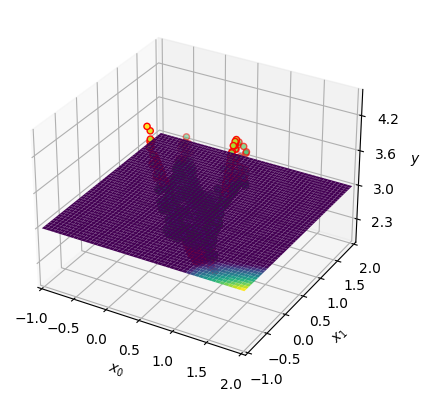

In [39]:
# Plot the performance on the train data
from lib.widgets.mlp_response_view import MLPResponseView
MLPResponseView(mlp, x_train, t_train, tolerance=0.5, proj_3d=True)

In [40]:
# Function to compute the amound of loss for x and y values
@torch.no_grad()
def get_total_loss(model, x, y, loss_fn):
    # Pass the validation data through the model
    y_pred = model(x)

    # Compute the loss value
    loss = loss_fn(y_pred, y)

    return loss

In [41]:
# Get the total loss for each of the datasets
train_loss = get_total_loss(mlp, x_train, t_train, loss_fn)
val_loss = get_total_loss(mlp, x_val, t_val, loss_fn)
test_loss = get_total_loss(mlp, x_test, t_test, loss_fn)

print(f'train: {train_loss}, val: {val_loss}, test: {test_loss}')

train: 0.1769006848335266, val: 0.17587466537952423, test: 0.16392455995082855


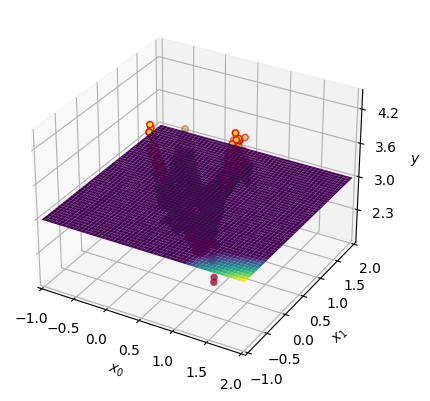

In [42]:
# Plot the performance on the test data
from lib.widgets.mlp_response_view import MLPResponseView
MLPResponseView(mlp, x_test, t_test, tolerance=0.5, proj_3d=True)